In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose,ToTensor,Normalize
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

### Create Dataset
<font size=2>
    
The original datasets **x_data** and **y_data** have the same shape which is: (32768, 30);
    
In order to intuitionally represent the structure of dataset, name the dimensions as:
    
    (32768, 30) -> (time_series, state)

where **time_series** is a time serial with 32768 time epoch, for each epoch there is a **state** with 30 features, i.e. with dimension of 30;
    
For example, x_data[i,j] represents: j-th feature of i-th epoch;
    
The task is to predict $y_{k}$ with **sub-serial** $[x_{k-m}, x_{k-m+1}, ..., x_{k+m-1}, x_{k+m}]$, which is similarly shown below (**m** is the **window** of prediction and can be adjusted for better trainning):
    
<div>
<img src="kiglis_task.png" style="zoom:60%"/>
</div>
    
then input dataset **x_data** should be adjusted. The new input dataset should have shape:
    
    (time_epoch, window_size, state) = (32768-2m, 2m+1, 30)
    
and target set should be like:
    
    (time_epoch, state) = (32768-2m, 30)

In [2]:
# create customized dataset
class kiglis_dataset(Dataset):
    
    def __init__(self, input_data, target_data):
        self.input = input_data
        self.target = target_data
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        inp = self.input[idx]
        tar = self.target[idx]
        return inp, tar

class KiglisLoader():

    def __init__(self, x_path, y_path, norm):
        self.x_path = x_path
        self.y_path = y_path
        # norm=0: dont normalize
        # norm=1: scale to N(0,1)
        # norm=2: scale to [0,1] (xi-x_min)/(x_max-x_min)
        self.norm = norm

    '''load original data'''
    def load_original_data(self):
        ori_x_data = np.array(pd.read_csv(self.x_path,delimiter=',',header=None))
        ori_y_data = np.array(pd.read_csv(self.y_path,delimiter=',',header=None))
        print("original x_data has shape of: {}".format(ori_x_data.shape))
        print("original y_data has shape of: {}".format(ori_y_data.shape))
        return ori_x_data, ori_y_data

    '''normalize data'''
    def normalize_dataset(self, data, norm=0):
        
        # norm=0: dont normalize
        new_data = torch.from_numpy(data)
        # norm=1: scale to N(0,1)
        if norm == 1:
            mean = torch.mean(new_data, axis=0, keepdims=True)
            std = torch.std(new_data, axis=0, keepdims=True)
            new_data = ((new_data - mean) / std)
            data = new_data
        # norm=2: scale to [0,1] (xi-x_min)/(x_max-x_min)
        if norm == 2:
            new_data = (data-torch.min(data,axis=0))/(torch.max(data,axis=0)-torch.min(data,axis=0))
        return new_data

    '''new data'''
    def new_data(self,norm_x_data, norm_y_data, ori_data_shape, m=20):
        # m: half window size, the whole window has size of (2m+1)
        # for now set m=20
        # ori_len_seq,state_size = ori_x_data.shape = 32768,30
        ori_len_seq = ori_data_shape[0]
        state_size = ori_data_shape[1]
        # x_data: (time_epoch, window_size, state) = (32768-2m, 2m+1, 30)
        # y_data: (time_epoch, state) = (32768-2m, 30)
        x_data = torch.zeros(ori_len_seq-2*m,2*m+1,state_size)
        y_data = torch.zeros(ori_len_seq-2*m,state_size)
        print("x_data has shape: {}".format(x_data.shape))
        print("y_data has shape: {}".format(y_data.shape))

        for i,j in zip(range(x_data.shape[0]),range(m,ori_len_seq-m)):
            x_data[i] = norm_x_data[j-m:j+m+1,:]
            y_data[i] = norm_y_data[j,:]
        
        return x_data, y_data

    '''data loader'''
    def data_loader(self, data_base, Len, BatchSize = 128, split = [0.6,0.2]):

        # Len: the length of input data
        # BatchSize: batch size
        # split: the ratio of train set and validation set, test set is 1-train-val

        train_size = int(Len*split[0])
        val_size = int(Len*split[1])
        train_idx = range(train_size)
        val_idx = range(train_size, train_size+val_size)
        test_idx = range(train_size+val_size, Len)
        # split dataset into train_set, validation_set, test_set
        train_db = Subset(data_base, train_idx)
        val_db = Subset(data_base, val_idx)
        test_db = Subset(data_base, test_idx)

        # create data_loaders
        train_loader = DataLoader(train_db, batch_size=BatchSize, shuffle=False)
        val_loader = DataLoader(val_db, batch_size=BatchSize, shuffle=False)
        test_loader = DataLoader(test_db, batch_size=BatchSize, shuffle=False)

        # show structure of data_loader
        print("length of train_loader: {}".format(len(train_loader)))
        element = next(iter(train_loader))
        print("element in train_loader is: {} with length {}".format(type(element),len(element)))
        input_batch = element[0]
        target_batch = element[1]
        print("one single input batch has shape {}".format(input_batch.shape))
        print("one single target batch has shape {}".format(target_batch.shape))

        return train_loader, val_loader, test_loader

    def create(self):
        # load original data
        ori_x_data, ori_y_data = self.load_original_data()
        # normalize original data
        norm_x_data = self.normalize_dataset(ori_x_data)
        norm_y_data = self.normalize_dataset(ori_y_data)
        # reshape original data
        x_data, y_data = self.new_data(norm_x_data,norm_y_data, ori_x_data.shape)
        # create dataset
        data_base = kiglis_dataset(x_data, y_data)
        # create dataloaders
        train_loader, val_loader, test_loader = self.data_loader(data_base, len(x_data))
        
        return train_loader, val_loader, test_loader, y_data

# if __name__ == "__main__":
#     x_path = 'x_data.txt'
#     y_path = 'y_data.txt'
#     kiglis_loader_creator = KiglisLoader(x_path, y_path, norm)
#     train_loader, val_loader, test_loader, y_data = kiglis_loader_creator.create()

original x_data has shape of: (32768, 30)
original y_data has shape of: (32768, 30)
x_data has shape: torch.Size([32728, 41, 30])
y_data has shape: torch.Size([32728, 30])
length of train_loader: 154
element in train_loader is: <class 'list'> with length 2
one single input batch has shape torch.Size([128, 41, 30])
one single target batch has shape torch.Size([128, 30])


### Construction of Network

In [5]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network,self).__init__()
        
        ###### parameters ######
        self.kernel = 6
        self.m = 30
        self.drop_ratio = 0.5
        self.CNNhid = 100
        self.RNNhid = 100
        
        ###### CNN ######
        # in: [128,1,41,30] [batch,channel,window_size,state_size]
        # out: [128,100,36] [batch,cnn_hidden,seq_len]
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=self.CNNhid,kernel_size=(self.kernel,self.m)),
            nn.Tanh(),
            nn.Dropout(self.drop_ratio)
        )
        
        ###### GRU ######
        # in: [36,128,100]
        # out: [1,128,100] [layer_num,batch,gru_hidden]
        self.gru = nn.GRU(input_size=self.CNNhid, hidden_size=self.RNNhid)
        
        ###### output ######
        self.output = nn.Sequential(
            nn.Linear(self.RNNhid,self.m),
            # nn.Sigmoid()
        )
        
    def forward(self,x):
        
        ###### CNN ######
        # to fit CNN layer:
        # from: [128,41,30] [batch,window_size,state_size]
        # to: [128,1,41,30] [batch,channel,window_size,state_size]
        x = x.unsqueeze(1)
        # in: [128,1,41,30] [batch,channel,window_size,state_size]
        # out: [128,100,36] [batch,cnn_hidden,seq_len]
        x = self.cnn(x)
        x = x.squeeze(3)
        
        ###### GRU ######
        # to fit GRU:
        # from: [128,100,36] [batch,cnn_hidden,seq_len]
        # to: [36,128,100] [seq_len,batch,cnn_hidden]
        x = x.permute(2,0,1).contiguous()
        # in: [36,128,100] [seq_len,batch,cnn_hidden]
        # out: [1,128,100] [layer_num,batch,gru_hidden]
        _, hidden = self.gru(x)
        self.gru_drop = nn.Dropout(self.drop_ratio)
        hidden = self.gru_drop(hidden.squeeze(0))
        
        ###### output ######
        # in: [128,100] [batch,gru_hidden]
        # out: [128,30] [batch,state_size]
        output = self.output(hidden)
        
        return output

# if __name__ == "__main__":
#     # input_data: [batch, window_size, state_size]
#     # output should have shape: [batch, state_size]
#     # e.g.
#     # input: [128,41,30] -> output: [128,30]
#     x = torch.randn(128,41,30)
#     model = Network()
#     out = model(x)
#     print("shape of output: {}".format(out.shape))

shape of output: torch.Size([128, 30])


### Training and Evaluation

original x_data has shape of: (32768, 30)
original y_data has shape of: (32768, 30)
x_data has shape: torch.Size([32728, 41, 30])
y_data has shape: torch.Size([32728, 30])
length of train_loader: 154
element in train_loader is: <class 'list'> with length 2
one single input batch has shape torch.Size([128, 41, 30])
one single target batch has shape torch.Size([128, 30])
Train Epoch: 0 [0/19636 (0%)]	Loss: 1.510284
Train Epoch: 0 [6400/19636 (32%)]	Loss: 0.373796
Train Epoch: 0 [12800/19636 (65%)]	Loss: 0.355474
Train Epoch: 0 [19200/19636 (97%)]	Loss: 0.367532

VAL set: Average loss: 0.3638

Train Epoch: 1 [0/19636 (0%)]	Loss: 0.354806
Train Epoch: 1 [6400/19636 (32%)]	Loss: 0.368034
Train Epoch: 1 [12800/19636 (65%)]	Loss: 0.354479
Train Epoch: 1 [19200/19636 (97%)]	Loss: 0.379016

VAL set: Average loss: 0.3602

Train Epoch: 2 [0/19636 (0%)]	Loss: 0.351027
Train Epoch: 2 [6400/19636 (32%)]	Loss: 0.344487
Train Epoch: 2 [12800/19636 (65%)]	Loss: 0.352138
Train Epoch: 2 [19200/19636 (97%

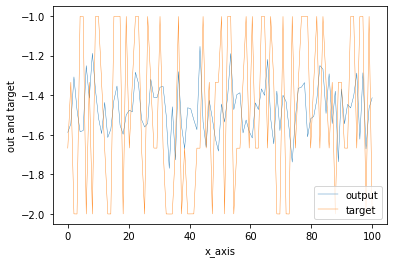

In [12]:
def get_loaders():
    norm=0
    x_path = 'x_data.txt'
    y_path = 'y_data.txt'
    kiglis_loader_creator = KiglisLoader(x_path, y_path, norm)
    # train_loader, val_loader, test_loader = kiglis_loader_creator.create()
    return kiglis_loader_creator.create()


if __name__ == "__main__":

    train_loader, val_loader, test_loader, y_data = get_loaders()
    device = torch.device('cuda:0')
    cpu = torch.device('cpu')
    model = Network().to(device)
    # loss will stay around 1.53, don't know why yet
    # all buffs are useless for improvment
    # adam can faster achieve loss=1.55 than sgd, which is reasonable
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
    scheduler = StepLR(optimizer,step_size=2,gamma=0.1)
    criterion = nn.L1Loss().to(device)
    
    '''training'''
    model.train()
    for epoch in range(10):

        for batch_idx,(data,target) in enumerate(train_loader):
            # normalize target into (0,1)
            # torch.min() and torch.max() return a tensor for value and a tensor for index
            # target = (target-torch.min(target,axis=0)[0])/(torch.max(target,axis=0)[0]-torch.min(target,axis=0)[0])
            data, target = data.to(device), target.cuda()
            out = model(data)
            loss = criterion(out,target)

            optimizer.zero_grad()
            loss.backward()
            grad_norm = optimizer.step()

            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
#                 print("grad_norm: {}".format(grad_norm))
        
        '''validation'''
        val_loss = 0
        for data, target in val_loader:
            # target = (target-torch.min(target,axis=0)[0])/(torch.max(target,axis=0)[0]-torch.min(target,axis=0)[0])
            data, target = data.to(device), target.cuda()
            out = model(data)
            val_loss += criterion(out, target).item()

        val_loss /= (len(val_loader.dataset)/128.0)
        print('\nVAL set: Average loss: {:.4f}\n'.format(val_loss))

        scheduler.step()
    
    '''testing'''
    model.eval()
    RSE_numerator = 0
    all_target = torch.zeros(0)
    all_out = torch.zeros(0).to(device)
    # RSE = sqrt(sum((pred_i-tarrget_i)**2)) / RSE_denominator
    # RSE_denominator = sqrt(sum((target_i-mean(target_all))**2))
    for data, target in test_loader:
        # target = (target-torch.min(target,axis=0)[0])/(torch.max(target,axis=0)[0]-torch.min(target,axis=0)[0])
        all_target = torch.cat((target,all_target),axis=0)
        data, target = data.to(device), target.cuda()
        out = model(data)
        all_out = torch.cat((out,all_out),axis=0)
        RSE_numerator += torch.sum((target-out)**2)
    # RSE metric
    RSE_denominator = torch.sqrt(torch.sum((all_target-torch.mean(all_target))**2))
    RSE_numerator = torch.sqrt(RSE_numerator)
    RSE_loss = RSE_numerator / RSE_denominator
    # CORR metric
    all_out = all_out.to(cpu)
    all_target = all_target.to(cpu)
    CORR_numerator = (all_out-torch.mean(all_out,axis=0))*(all_target-torch.mean(all_target,axis=0))
    CORR_numerator = torch.sum(CORR_numerator,axis=0)
    CORR_denominator = ((all_out-torch.mean(all_out,axis=0))**2)*((all_target-torch.mean(all_target,axis=0))**2)
    CORR_denominator = torch.sqrt(torch.sum(CORR_denominator,axis=0))
    CORR_loss = torch.sum(CORR_numerator / CORR_denominator)/(all_target.shape[1])
    print('\nTEST set: RSE = {:.4f}\n'.format(RSE_loss))
    print('\nTEST set: CORR = {:.4f}\n'.format(CORR_loss))

    # [32728,30] -> [30,32728]
    all_out = all_out.t()
    all_out = np.array(all_out.detach())
    all_target = all_target.t()
    all_target = np.array(all_target.detach())

    x = np.linspace(0,100,100)
    plt.plot(x,all_out[0][0:100],linewidth=0.4,label="output")
    plt.plot(x,all_target[0][0:100],linewidth=0.4,label="target")
    plt.xlabel("x_axis")
    plt.ylabel("out and target")
    plt.legend()
    plt.show()